# Mask R-CNN - Inspect Training Data

Inspect and visualize data loading and pre-processing code.

In [ ]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline

/home/ec2-user/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/maskrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-user/anaconda3/envs/mask

## Configurations

Run one of the code blocks below to import and load the configurations to use.

In [ ]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()


import bdd100k
config = bdd100k.Bdd100kConfig()
COCO_DIR = 'content/drive/datasets/bdd100k/'  # TODO: enter value here


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  720
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

## Dataset

In [ ]:
# Load dataset
dataset = bdd100k.Bdd100kDataset()
dataset.load_bdd100k('content/drive/datasets/bdd100k/val/ins_seg_val_cocofmt.json', '../../datasets/bdd100k/val')

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

100%|██████████| 1000/1000 [00:00<00:00, 80644.18it/s]

Image Count: 1000
Class Count: 9
  0. BG                                                
  1. pedestrian                                        
  2. rider                                             
  3. car                                               
  4. truck                                             
  5. bus                                               
  6. train                                             
  7. motorcycle                                        
  8. bicycle                                           


## Display Samples

Load and display images and masks.

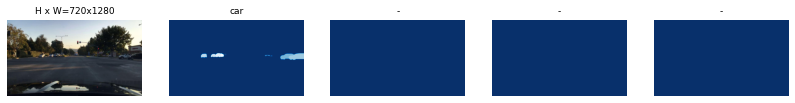

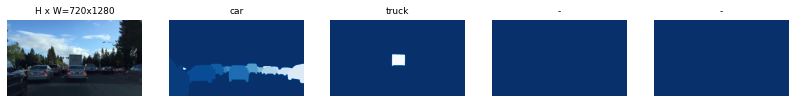

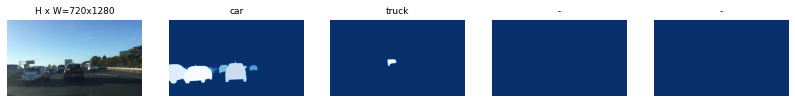

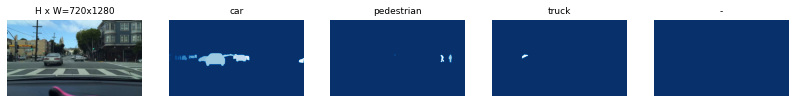

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

image_id  576 577
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
mask                     shape: (720, 1280, 4)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (4,)                  min:    3.00000  max:    3.00000  int32
bbox                     shape: (4, 4)                min:  256.00000  max:  564.00000  int32


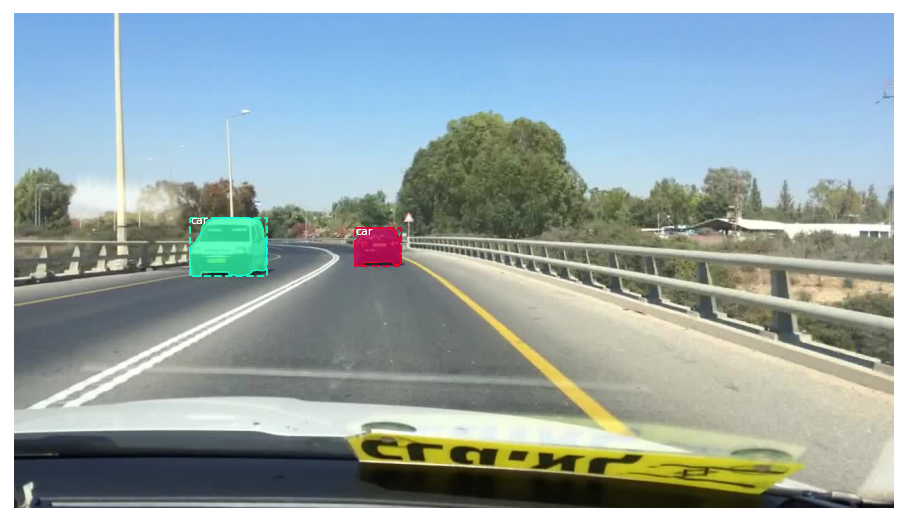

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Resize Images

image_id:  94 95
Original shape:  (720, 1280, 3)
image                    shape: (1280, 1280, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1280, 1280, 26)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (26,)                 min:    1.00000  max:    3.00000  int32
bbox                     shape: (26, 4)               min:    0.00000  max:  758.00000  int32


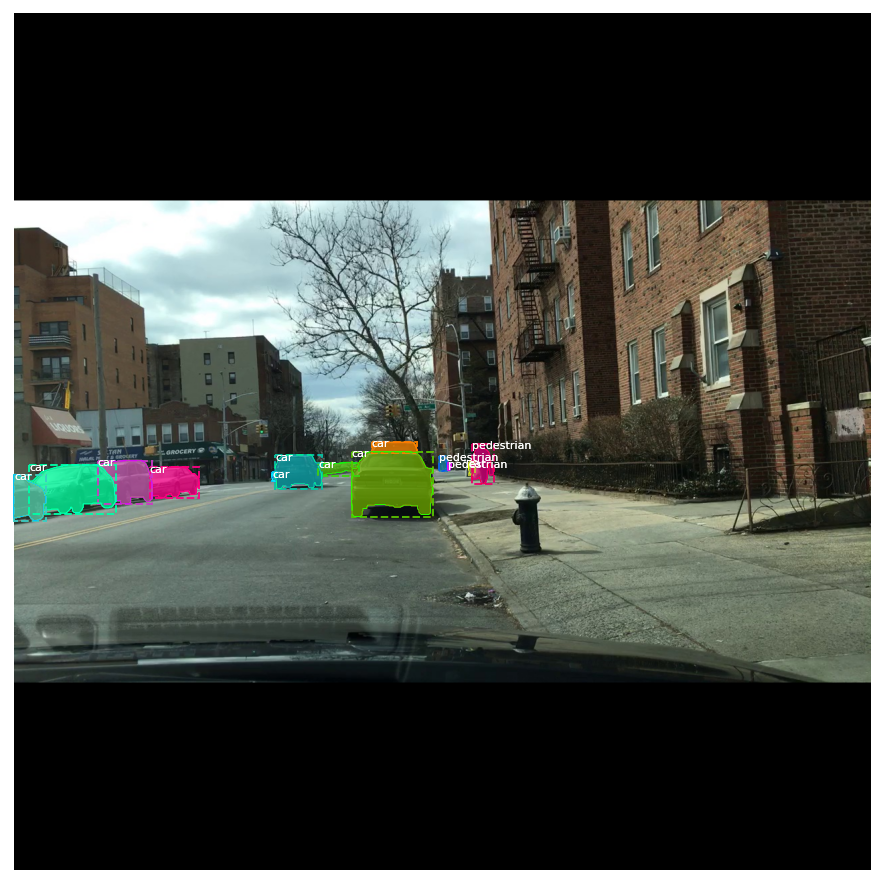

In [ ]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image,
    min_dim=config.IMAGE_MIN_DIM,
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

image                    shape: (1280, 1280, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (21,)                 min:    0.00000  max: 1280.00000  int64
class_ids                shape: (40,)                 min:    1.00000  max:    8.00000  int32
bbox                     shape: (40, 4)               min:  324.00000  max: 1280.00000  int32
mask                     shape: (1280, 1280, 40)      min:    0.00000  max:    1.00000  bool


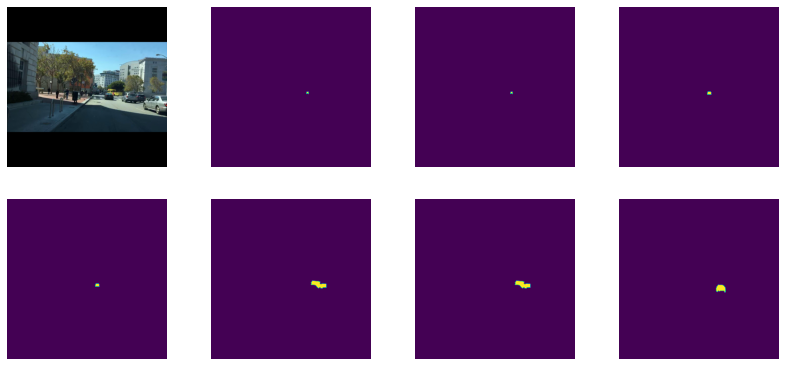

In [ ]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

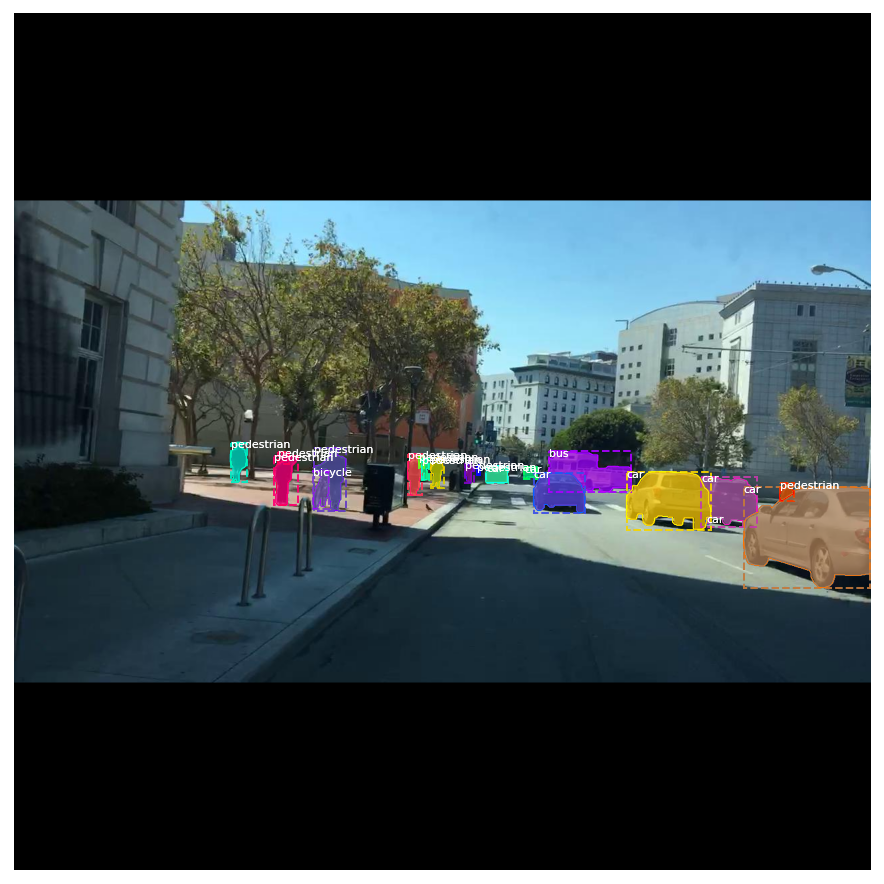

In [ ]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 40)          min:    0.00000  max:    1.00000  bool


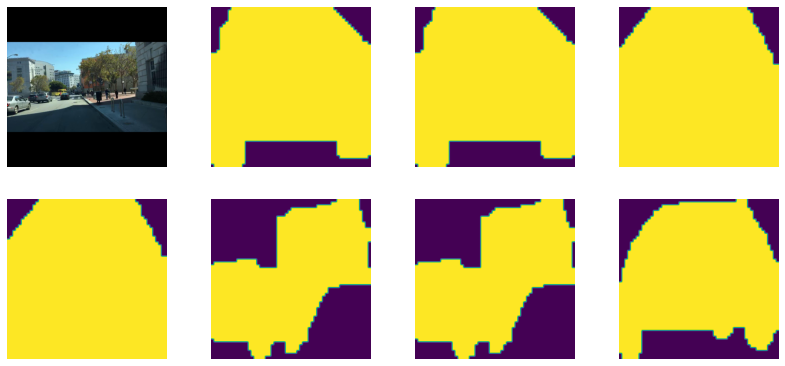

In [ ]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

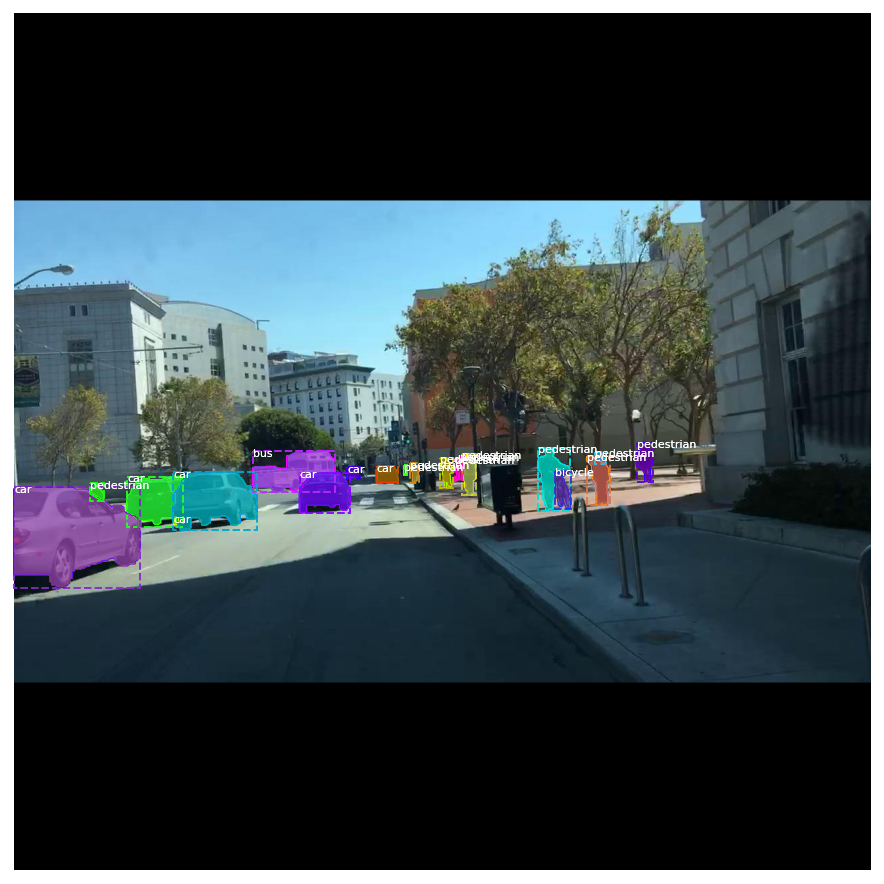

In [ ]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

In [ ]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES,
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  409200
Scales:  (8, 16, 32, 64, 128)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 307200
Anchors in Level 1: 76800
Anchors in Level 2: 19200
Anchors in Level 3: 4800
Anchors in Level 4: 1200


Visualize anchors of one cell at the center of the feature map of a specific level.

Level 0. Anchors: 307200  Feature map Shape: [320 320]
Level 1. Anchors:  76800  Feature map Shape: [160 160]
Level 2. Anchors:  19200  Feature map Shape: [80 80]
Level 3. Anchors:   4800  Feature map Shape: [40 40]
Level 4. Anchors:   1200  Feature map Shape: [20 20]


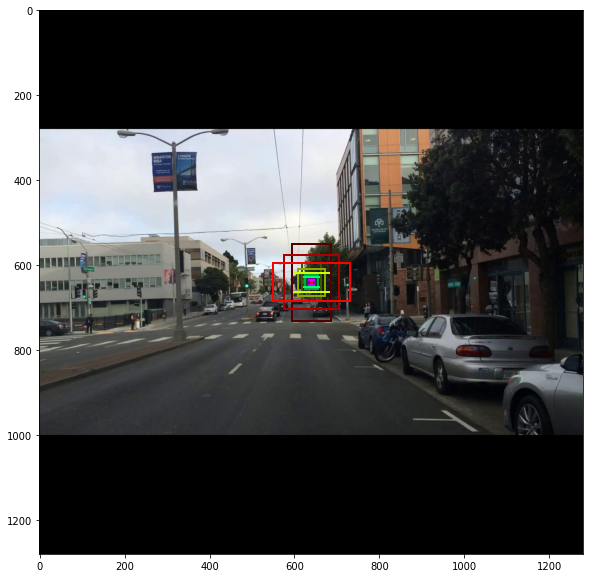

In [ ]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0],
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator


In [ ]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois,
    batch_size=4,
    detection_targets=True)

In [ ]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)

    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)

log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 128, 4)           min:    0.00000  max: 1279.00000  int32
mrcnn_class_ids          shape: (4, 128, 1)           min:    0.00000  max:    3.00000  int32
mrcnn_bbox               shape: (4, 128, 9, 4)        min:   -3.94737  max:    3.57143  float32
mrcnn_mask               shape: (4, 128, 28, 28, 9)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 200)              min:    0.00000  max:    3.00000  int32
gt_boxes                 shape: (4, 200, 4)           min:    0.00000  max: 1280.00000  int32
gt_masks                 shape: (4, 56, 56, 200)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 409200, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 64, 4)            min:   -4.88898  max:   14.25262  float64
image_id:  775 776


anchors                  shape: (409200, 4)           min:  -90.50967  max: 1306.50967  float64
refined_anchors          shape: (30, 4)               min:    0.00000  max: 1279.00000  float32
Positive anchors: 30
Negative anchors: 34
Neutral anchors: 409136
BG                     : 95
car                    : 33


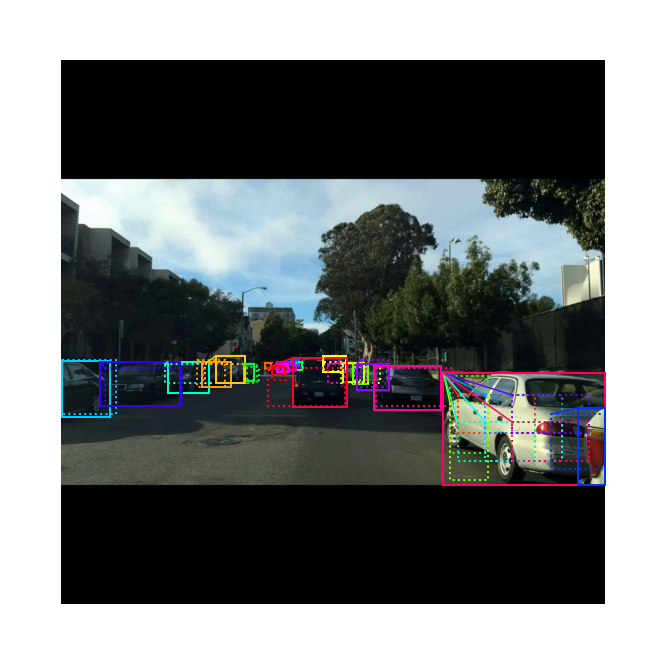

In [ ]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids],
                     refined_boxes=refined_anchors)

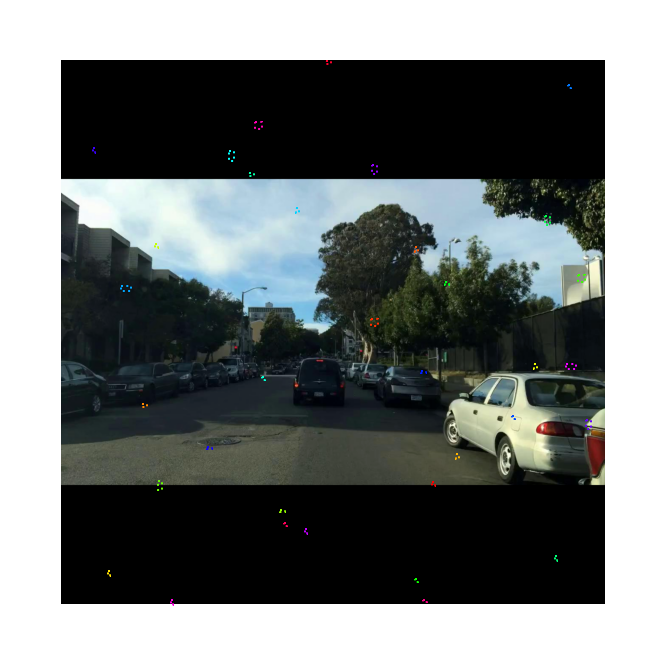

In [ ]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

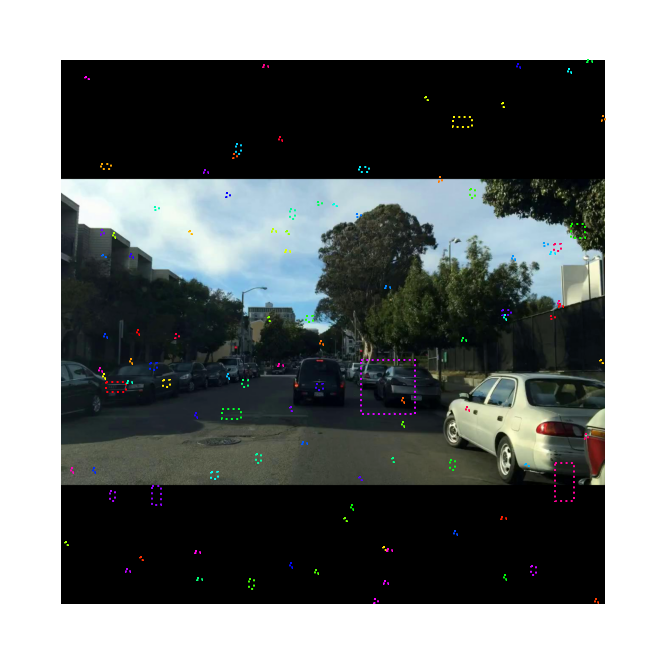

In [ ]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  33
Negative ROIs:  95
Positive Ratio: 0.26
Unique ROIs: 128 out of 128


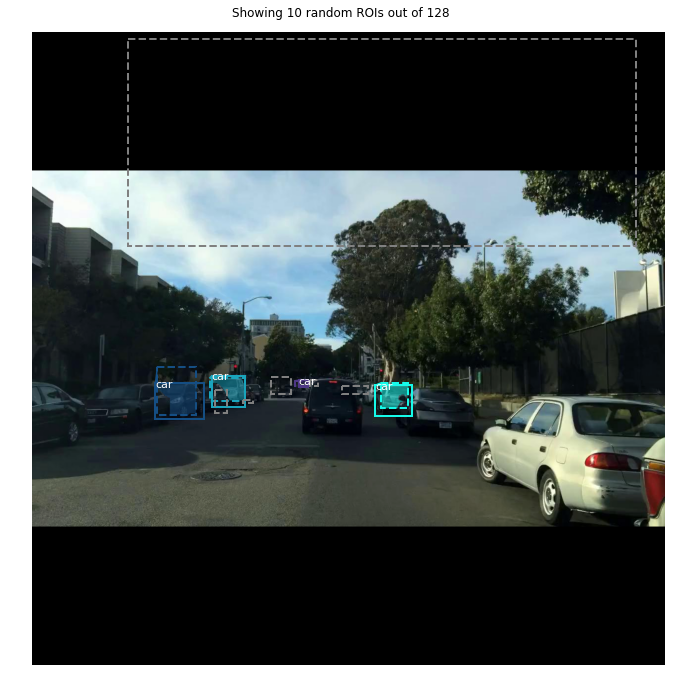

In [ ]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)

    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

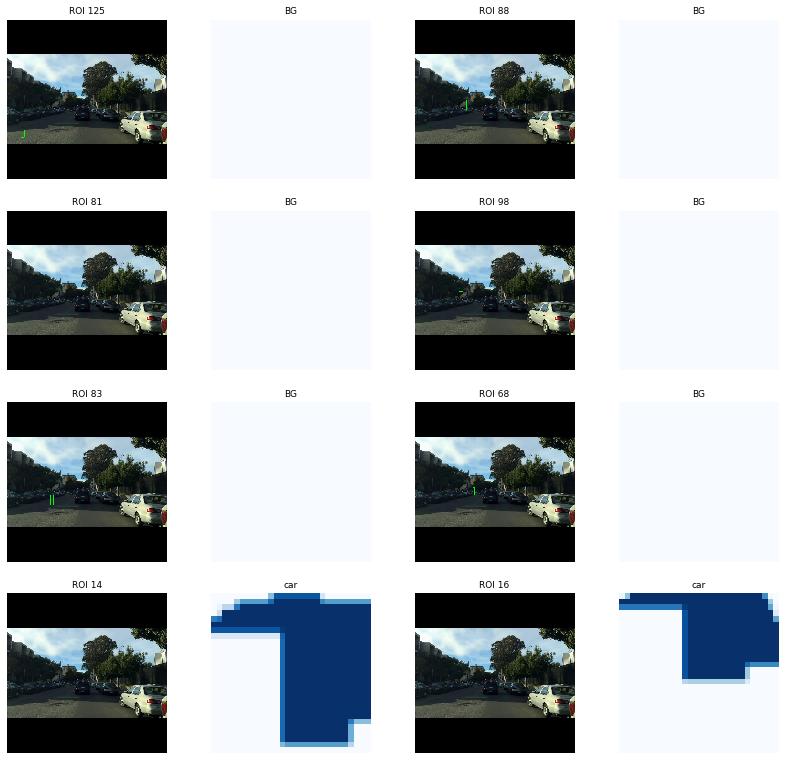

In [ ]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [ ]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000,
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
Average percent: 0.33
